In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1-cp38-cp38-manylinux1_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.8.1
    Uninstalling transformers-4.8.1:
      Successfully uninstalled transformers-4.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [2]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-z4z50rhh
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-z4z50rhh
  Using cached transformers-4.8.1-py3-none-any.whl (2.5 MB)
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.8.1rc1
    Uninstalling tokenizers-0.8.1rc1:
      Successfully uninstalled tokenizers-0.8.1rc1
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import urllib.request

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
#GPU 사용
device = torch.device("cuda:0")

In [6]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [7]:
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv('/content/drive/MyDrive/oliveyoung_3.csv')

In [16]:
df.sample(n=10)

,name,review,stars,comments
5102,['바이오힐보 비타민 토닝 기미잡티세럼'],피부타입\n건성에 좋아요\n피부고민\n주름/미백에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,여름이라 마스크쓴 쪽은 열감때메 자극이고\n눈가쪽과 이마는 자외선과 전쟁이라\n기미...
17580,['넘버즈인 3번 보들보들 결 세럼'],피부타입\n복합성에 좋아요\n피부고민\n주름/미백에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,⭐️ 쫀쫀 ⭐️ 보습 ⭐️ 가벼운 발림성 ⭐️ 매끈한 결 케어 ⭐️ \n\n넘버즈인...
9506,['코스알엑스 풀핏 프로폴리스 라이트 앰플'],피부타입\n복합성에 좋아요\n피부고민\n진정에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,복합성에 민감성 피부이며 세안 후 건조함을 느끼는 타입인 저에게는 딱 맞는 제품입니...
15128,['아이소이 잡티세럼'],피부타입\n건성에 좋아요\n피부고민\n주름/미백에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,진짜 너무 좋고 제가 애정하는 아이템이에요ㅠㅠ 요거 또 사려했더니 판매 종료되어서 ...
5411,['바이오힐보 비타민 토닝 기미잡티세럼'],피부타입\n복합성에 좋아요\n피부고민\n보습에 좋아요\n자극도\n보통이에요,5점만점에 4점,아직 큰 효과를 모르겠지만 보습은 되는 것 같아요\n약간 기름지는 느낌ㅋㅋㅋㅋㅋㅋ ...
7846,['셀리맥스 더 리얼 노니 에너지 앰플'],피부타입\n건성에 좋아요\n피부고민\n보습에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,정말 몇통째 구매해서 쓰고있는지 모르겠어요.\n피부가 건성인 편이라 사계절용으로 사...
681,['아비브 어성초 에센스'],피부타입\n복합성에 좋아요\n피부고민\n보습에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,수분 에센스 유목민이라서 정말 다양한 제품들을 사용해 봤거든요..\n근데 지금까지 ...
920,['아비브 어성초 에센스'],피부타입\n복합성에 좋아요\n피부고민\n진정에 좋아요\n자극도\n보통이에요,5점만점에 5점,아비브! 광고로 정말 많이 보던 브랜드에요 항상 광고를 보면서 저 브랜드는 어쩜 저...
1421,['에스트라 에이시카365 흔적 진정 세럼'],피부타입\n복합성에 좋아요\n피부고민\n진정에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,순하고 묽은 에센스인데 성분이 좋더라구요. 마스크때문에 턱이랑 얼굴 사이드에 뾰루지...
934,['아비브 어성초 에센스'],피부타입\n복합성에 좋아요\n피부고민\n진정에 좋아요\n자극도\n자극없이 순해요,5점만점에 5점,저번에 구매했던 아비브 어성초 마스크팩이 저랑 잘 맞는 것 같아서 이번에 구매해봤어...


In [17]:
# 결측치 제거 후 확인

df = df.dropna(axis = 0)
df.shape

(22927, 4)

In [18]:
# 중복값 제거 후 확인

df.drop_duplicates(inplace=True)
df.shape

(22791, 4)

In [19]:
df = df.dropna(axis = 0)
df.shape

(22791, 4)

In [62]:
# review 한글과 공백 제외하고 모두 제거

df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df[:5]

<ipython-input-62-3fc300e167b2>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-62-3fc300e167b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,name,review,stars,comments,skintype,skin_trouble,skin_irritation
0,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존...,2,0,0
1,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,대남성악지성지성발효 티트리염증성 트러블 종종산뜻한 제형 선호 구매 사유 이 때 ...,2,0,0
2,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 3점,피부 타입 수부지 트러블 예민 열감 잘 오름 유분과 과영양 외부환경에 예민 ...,2,1,0
3,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기아비브 어성초 마스크팩 을 너무너무 잘 쓰고 있어서 기초를 아예 아비브 로 ...,2,0,0
4,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기 아비브 어성초 마스크 팩이 제 피부와 너무나 잘 맞았고 사용 후 예민해...,2,1,0


In [63]:
# comments 한글과 공백 제외하고 모두 제거

df['comments'] = df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df[:5]

<ipython-input-63-5668011dc271>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comments'] = df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-63-5668011dc271>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,name,review,stars,comments,skintype,skin_trouble,skin_irritation
0,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존...,2,0,0
1,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,대남성악지성지성발효 티트리염증성 트러블 종종산뜻한 제형 선호 구매 사유 이 때 ...,2,0,0
2,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 3점,피부 타입 수부지 트러블 예민 열감 잘 오름 유분과 과영양 외부환경에 예민 ...,2,1,0
3,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기아비브 어성초 마스크팩 을 너무너무 잘 쓰고 있어서 기초를 아예 아비브 로 ...,2,0,0
4,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기 아비브 어성초 마스크 팩이 제 피부와 너무나 잘 맞았고 사용 후 예민해...,2,1,0


In [64]:
df["skintype"] = ''

df['skintype'][df['review'].str.contains('건성')] = 0 
df['skintype'][df['review'].str.contains('지성')] = 1 
df['skintype'][df['review'].str.contains('복합성')] = 2 

df

<ipython-input-64-fb28947a289f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["skintype"] = ''
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,name,review,stars,comments,skintype,skin_trouble,skin_irritation
0,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존...,2,0,0
1,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,대남성악지성지성발효 티트리염증성 트러블 종종산뜻한 제형 선호 구매 사유 이 때 ...,2,0,0
2,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 3점,피부 타입 수부지 트러블 예민 열감 잘 오름 유분과 과영양 외부환경에 예민 ...,2,1,0
3,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기아비브 어성초 마스크팩 을 너무너무 잘 쓰고 있어서 기초를 아예 아비브 로 ...,2,0,0
4,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기 아비브 어성초 마스크 팩이 제 피부와 너무나 잘 맞았고 사용 후 예민해...,2,1,0
...,...,...,...,...,...,...,...
23079,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,살짝 끈적함 마무리감이 있긴해요 그래도 이거 이후에 크림을 발라줘야 하잖아요 그래서...,2,1,0
23080,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도보통이에요,5점만점에 5점,전에 통 쓰고 이번에 재구매했습니다수부지인데도 겨울에 쓰기엔 건조할 거 같고 지금 ...,2,0,1
23081,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,이거쓰고 속당김 많이 완화된 느낌근데 건성인분들은 반드시 보습지품 덧발라주셔야되여웃...,2,1,0
23082,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입지성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,이 제품 몇통째인지 모르겠어요 ㅜ좋다는 세럼 나름 이것저것 써 본 사람인데결국 정착...,1,1,0


In [65]:
df["skin_trouble"] = ''

df['skin_trouble'][df['review'].str.contains('진정')] = 0 
df['skin_trouble'][df['review'].str.contains('보습')] = 1 
df['skin_trouble'][df['review'].str.contains('주름')] = 2 

df

<ipython-input-65-bb2b417492e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["skin_trouble"] = ''
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,name,review,stars,comments,skintype,skin_trouble,skin_irritation
0,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존...,2,0,0
1,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,대남성악지성지성발효 티트리염증성 트러블 종종산뜻한 제형 선호 구매 사유 이 때 ...,2,0,0
2,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 3점,피부 타입 수부지 트러블 예민 열감 잘 오름 유분과 과영양 외부환경에 예민 ...,2,1,0
3,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기아비브 어성초 마스크팩 을 너무너무 잘 쓰고 있어서 기초를 아예 아비브 로 ...,2,0,0
4,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기 아비브 어성초 마스크 팩이 제 피부와 너무나 잘 맞았고 사용 후 예민해...,2,1,0
...,...,...,...,...,...,...,...
23079,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,살짝 끈적함 마무리감이 있긴해요 그래도 이거 이후에 크림을 발라줘야 하잖아요 그래서...,2,1,0
23080,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도보통이에요,5점만점에 5점,전에 통 쓰고 이번에 재구매했습니다수부지인데도 겨울에 쓰기엔 건조할 거 같고 지금 ...,2,0,1
23081,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,이거쓰고 속당김 많이 완화된 느낌근데 건성인분들은 반드시 보습지품 덧발라주셔야되여웃...,2,1,0
23082,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입지성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,이 제품 몇통째인지 모르겠어요 ㅜ좋다는 세럼 나름 이것저것 써 본 사람인데결국 정착...,1,1,0


In [66]:
df["skin_irritation"] = ''

df['skin_irritation'][df['review'].str.contains('순해요')] = 0 
df['skin_irritation'][df['review'].str.contains('보통')] = 1 
df['skin_irritation'][df['review'].str.contains('느껴져요')] = 2 

df

<ipython-input-66-268cbc05aac5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["skin_irritation"] = ''
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,name,review,stars,comments,skintype,skin_trouble,skin_irritation
0,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존...,2,0,0
1,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 4점,대남성악지성지성발효 티트리염증성 트러블 종종산뜻한 제형 선호 구매 사유 이 때 ...,2,0,0
2,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 3점,피부 타입 수부지 트러블 예민 열감 잘 오름 유분과 과영양 외부환경에 예민 ...,2,1,0
3,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기아비브 어성초 마스크팩 을 너무너무 잘 쓰고 있어서 기초를 아예 아비브 로 ...,2,0,0
4,['아비브 어성초 에센스'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,구매계기 아비브 어성초 마스크 팩이 제 피부와 너무나 잘 맞았고 사용 후 예민해...,2,1,0
...,...,...,...,...,...,...,...
23079,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,살짝 끈적함 마무리감이 있긴해요 그래도 이거 이후에 크림을 발라줘야 하잖아요 그래서...,2,1,0
23080,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민진정에 좋아요자극도보통이에요,5점만점에 5점,전에 통 쓰고 이번에 재구매했습니다수부지인데도 겨울에 쓰기엔 건조할 거 같고 지금 ...,2,0,1
23081,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입복합성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,이거쓰고 속당김 많이 완화된 느낌근데 건성인분들은 반드시 보습지품 덧발라주셔야되여웃...,2,1,0
23082,['토리든 다이브인 저분자 히알루론산 세럼'],피부타입지성에 좋아요피부고민보습에 좋아요자극도자극없이 순해요,5점만점에 5점,이 제품 몇통째인지 모르겠어요 ㅜ좋다는 세럼 나름 이것저것 써 본 사람인데결국 정착...,1,1,0


In [67]:
data_list = []
for q, label in zip(df['comments'], df['skintype'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [68]:
print(data_list[0])
print(data_list[-1])

['기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존 대비 개선된 사항  패키지 개선  기존 흰색 제품은 불투명한 용기 때문에 내용물이 얼마나 남았는지 알기 어려웠습니다 이제 반투명한 용기로 리뉴얼 되어 남은 양을 알기 쉽고 컬러도 연두색이라 아비브 어성초 라인이 전체적으로 통일감 있어졌네요 성분 개선  기존 아비브 제품은 알러지 유발 성분인 리모넨 리날룰이 들어가있어 극도로 민감한 피부는 알러지 반응을 보였으나 이 성분들이 빠지면서 더욱 더 순해졌어요 논코메도제닉 테스트 완료  모공을 막아 피부 트러블을유발하는 제품이 아니라는 테스트라고 하는데 원래도 트러블이 유발되는 제품이 아닌 순한 제품이었는데 더 안심하고 사용할 수 있을 거 같아요기존 대비 아쉬운 점 사용감  기존 제품의 사용감을 좋아했던 사람으로서 개인적으로 너무 아쉬운 부분 입니다 기존대비 묽어진 사용감 입니다 유분감이 줄었고 수분감이 늘었어요 약간 끈적인다 하셨던 분들께는 희소식 그 약간의 끈적임을 즐기셨던 저같은 분들께는 슬픈 소식이 되겠네요 다만 기존 대비 두 배로 사용하면 어느정도 비슷한 효과는 있는 거 같습니다 향  리모넨 리날룰 두 제품이 빠지면서 성분은 좋아졌지만 기존의 향기는 사라지고 거의 무향 원료향에 가까운 향만 남았습니다 이 점 역시 무향을 선호하시는 분들껜 기쁜 소식이겠습니다만 기존 향을 좋아하던 분들께서는 아쉬워할 거 같네요 속당김 개선  속이 당긴다고 표현하기에는 촉촉하지만 리뉴얼 전 제품이 더 속당김을 잘 잡아줬던 거 같아요 한 통 다 비울 때까지 꾸준히 사용해봐야 정확한 판단이 될 거 같아 우선 계속 사용해보려 합니다꽤 성공적인 리뉴얼 인 것 같지만 기존 제품의 엄청난 팬으로서는 약간 아쉽다 정도 인 거 같아요 재구매 의사는 한 통 다 비우고 나야 알 것 같습니다 과연 기존 제품처럼 사계절 사용이 가능할지 저도 궁금하네요저의 리뷰가 도움이 되셨다면 좋아요 꾹 눌러주세요즐거운 일 가득한 하루가 되시기 바랍니다 ', '2']
['요새 마스크

In [69]:
# train - test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)

In [70]:
print(len(dataset_train))
print(len(dataset_test))

18156
4540


In [71]:
# 데이터가 KoBERT 모델의 입력으로 들어갈 수 있는 형태가 되도록 토큰화, 정수 인코딩, 패딩

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [102]:
# Setting parameters

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 2
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [38]:
#토큰화  <- 여기서 에러남 (정상..?이라고 해야하나.. 당연히 에러남..?)

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


ValueError: ignored

In [39]:
# 진짜 찾는 거 최고 오래 걸린 에러...!!!!!

# pd의 isnull 옵션이 누락 된 값을 인식하지 못할 수도 있음
# np.nan사용하여 빈칸을 NaN으로 변환한 다음 dropna() 다시 사용해서 결측값 삭제

df.replace('', np.nan, inplace=True)

In [73]:
df.isnull().sum()

name               0
review             0
stars              0
comments           0
skintype           0
skin_trouble       0
skin_irritation    0
dtype: int64

In [74]:
df = df.dropna(axis = 0)
df.shape

(22696, 7)

###⭐⭐⭐⭐⭐

- 다시 돌아가서 

- "reviews 한글과 공백 제외하고 모두 제거"

- 여기부터 다시 하고 오기

- 0 1 2 <- 여기에 소숫점이 붙어서 또 에러나기 때문

- 똑같은 걸 두 번 해야 됐던 기억이..?

- 이건 왜 두 번 해야되는지 모르겠음.. ㅠ

In [82]:
# 다시 토큰화

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [83]:
data_train[0]

(array([   2, 3650, 5859, 4206, 5439, 5007, 2573, 6395, 5761, 4841, 5859,
        1562, 4204, 5842, 5850, 4128, 4910, 6901, 4208, 7083, 4204, 5405,
        6857, 3129, 2613, 7207,    3,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(27, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [84]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [103]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 0, 1, 2##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [104]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [105]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-105-480b6a139979>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.0976123809814453 train acc 0.359375
epoch 1 batch id 201 loss 0.7573105692863464 train acc 0.6427238805970149
epoch 1 train acc 0.6388894446222791


<ipython-input-105-480b6a139979>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 1 test acc 0.5635416666666666


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6897774934768677 train acc 0.6875
epoch 2 batch id 201 loss 0.6578025221824646 train acc 0.7160292288557214
epoch 2 train acc 0.7086717749679897


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 2 test acc 0.5598444835680751


- 에포크 2일때가 가장 높았음 (아래 사진 참고)

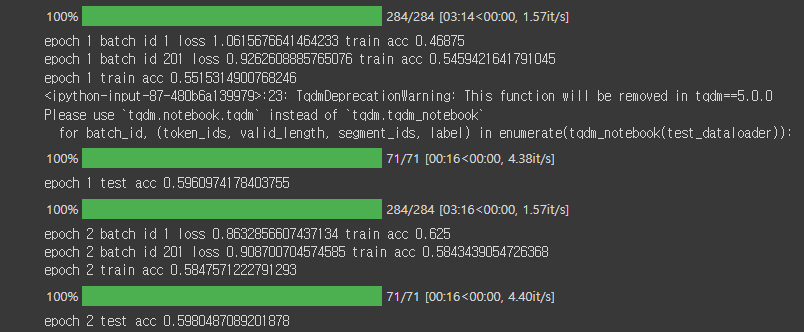

In [99]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("건성")
            elif np.argmax(logits) == 1:
                test_eval.append("지성")
            elif np.argmax(logits) == 2:
                test_eval.append("복합성")
            
        print(">> 검색하신 고민은 " + test_eval[0] + "과 관련한 고민이라고 추정됩니다.  " + test_eval[0] + "과 관련한 화장품을 찾아보세요 ! ")

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [101]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("피부 고민을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

피부 고민을 입력해주세요 : 사계절 내내 건조해요
>> 검색하신 고민은 건성과 관련한 고민이라고 생각됩니다.  건성과 관련한 화장품을 찾아보세요! :) 


피부 고민을 입력해주세요 : T존 유분이 없어졌으면 좋겠어요
>> 검색하신 고민은 복합성과 관련한 고민이라고 생각됩니다.  복합성과 관련한 화장품을 찾아보세요! :) 


피부 고민을 입력해주세요 : 겨울에도 악지성이에요
>> 검색하신 고민은 지성과 관련한 고민이라고 생각됩니다.  지성과 관련한 화장품을 찾아보세요! :) 


피부 고민을 입력해주세요 : 피부가 푸석해요
>> 검색하신 고민은 건성과 관련한 고민이라고 생각됩니다.  건성과 관련한 화장품을 찾아보세요! :) 


피부 고민을 입력해주세요 : 수분감이 많은 걸 원해요
>> 검색하신 고민은 복합성과 관련한 고민이라고 생각됩니다.  복합성과 관련한 화장품을 찾아보세요! :) 


피부 고민을 입력해주세요 : 수부지를 위한 세럼
>> 검색하신 고민은 지성과 관련한 고민이라고 생각됩니다.  지성과 관련한 화장품을 찾아보세요! :) 




KeyboardInterrupt: ignored

## 2번 모델

In [106]:
data_list = []
for q, label in zip(df['comments'], df['skin_trouble'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [107]:
print(data_list[0])
print(data_list[-1])

['기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존 대비 개선된 사항  패키지 개선  기존 흰색 제품은 불투명한 용기 때문에 내용물이 얼마나 남았는지 알기 어려웠습니다 이제 반투명한 용기로 리뉴얼 되어 남은 양을 알기 쉽고 컬러도 연두색이라 아비브 어성초 라인이 전체적으로 통일감 있어졌네요 성분 개선  기존 아비브 제품은 알러지 유발 성분인 리모넨 리날룰이 들어가있어 극도로 민감한 피부는 알러지 반응을 보였으나 이 성분들이 빠지면서 더욱 더 순해졌어요 논코메도제닉 테스트 완료  모공을 막아 피부 트러블을유발하는 제품이 아니라는 테스트라고 하는데 원래도 트러블이 유발되는 제품이 아닌 순한 제품이었는데 더 안심하고 사용할 수 있을 거 같아요기존 대비 아쉬운 점 사용감  기존 제품의 사용감을 좋아했던 사람으로서 개인적으로 너무 아쉬운 부분 입니다 기존대비 묽어진 사용감 입니다 유분감이 줄었고 수분감이 늘었어요 약간 끈적인다 하셨던 분들께는 희소식 그 약간의 끈적임을 즐기셨던 저같은 분들께는 슬픈 소식이 되겠네요 다만 기존 대비 두 배로 사용하면 어느정도 비슷한 효과는 있는 거 같습니다 향  리모넨 리날룰 두 제품이 빠지면서 성분은 좋아졌지만 기존의 향기는 사라지고 거의 무향 원료향에 가까운 향만 남았습니다 이 점 역시 무향을 선호하시는 분들껜 기쁜 소식이겠습니다만 기존 향을 좋아하던 분들께서는 아쉬워할 거 같네요 속당김 개선  속이 당긴다고 표현하기에는 촉촉하지만 리뉴얼 전 제품이 더 속당김을 잘 잡아줬던 거 같아요 한 통 다 비울 때까지 꾸준히 사용해봐야 정확한 판단이 될 거 같아 우선 계속 사용해보려 합니다꽤 성공적인 리뉴얼 인 것 같지만 기존 제품의 엄청난 팬으로서는 약간 아쉽다 정도 인 거 같아요 재구매 의사는 한 통 다 비우고 나야 알 것 같습니다 과연 기존 제품처럼 사계절 사용이 가능할지 저도 궁금하네요저의 리뷰가 도움이 되셨다면 좋아요 꾹 눌러주세요즐거운 일 가득한 하루가 되시기 바랍니다 ', '0']
['요새 마스크

In [108]:
# train - test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)

In [109]:
print(len(dataset_train))
print(len(dataset_test))

18156
4540


In [110]:
# 데이터가 KoBERT 모델의 입력으로 들어갈 수 있는 형태가 되도록 토큰화, 정수 인코딩, 패딩

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [111]:
# Setting parameters

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [112]:
# 토큰화

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [113]:
data_train[0]

(array([   2, 3650, 5859, 4206, 5439, 5007, 2573, 6395, 5761, 4841, 5859,
        1562, 4204, 5842, 5850, 4128, 4910, 6901, 4208, 7083, 4204, 5405,
        6857, 3129, 2613, 7207,    3,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(27, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [114]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [115]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 0, 1, 2##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [116]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-116-480b6a139979>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.1661174297332764 train acc 0.203125
epoch 1 batch id 201 loss 1.0425939559936523 train acc 0.35657649253731344
epoch 1 train acc 0.40869578265044815


<ipython-input-116-480b6a139979>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 1 test acc 0.576056338028169


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8587314486503601 train acc 0.625
epoch 2 batch id 201 loss 0.9321295022964478 train acc 0.5949160447761194
epoch 2 train acc 0.6025128040973112


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 2 test acc 0.6107834507042254


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7895500659942627 train acc 0.671875
epoch 3 batch id 201 loss 0.810996413230896 train acc 0.6606809701492538
epoch 3 train acc 0.6712898127400768


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 3 test acc 0.6063967136150235


- 마찬가지로 에포크 2번이 가장 성능 높음

In [117]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("진정")
            elif np.argmax(logits) == 1:
                test_eval.append("보습")
            elif np.argmax(logits) == 2:
                test_eval.append("주름/미백")
            
        print(">> 검색하신 세럼은 " + test_eval[0] + "과 관련한 세럼입니다.")

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [120]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("원하는 세럼을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

원하는 세럼을 입력해주세요 : 에스트라 에이시카365 흔적 진정 세럼
>> 검색하신 세럼은 진정과 관련한 세럼이라고 유추됩니다.


원하는 세럼을 입력해주세요 : 아벤느 이드랑스 에센스 인 로션
>> 검색하신 세럼은 보습과 관련한 세럼이라고 유추됩니다.


원하는 세럼을 입력해주세요 : 구달 청귤 비타C 잡티케어 세럼
>> 검색하신 세럼은 주름/미백과 관련한 세럼이라고 유추됩니다.


원하는 세럼을 입력해주세요 : 브링그린 사철쑥카밍인텐시브세럼
>> 검색하신 세럼은 진정과 관련한 세럼이라고 유추됩니다.


원하는 세럼을 입력해주세요 : 차앤박(CNP) 프로폴리스 에너지 액티브 앰플
>> 검색하신 세럼은 보습과 관련한 세럼이라고 유추됩니다.


원하는 세럼을 입력해주세요 : 닥터디퍼런트 씨이큐 안티옥시던트 세럼
>> 검색하신 세럼은 주름/미백과 관련한 세럼이라고 유추됩니다.


원하는 세럼을 입력해주세요 : 디오디너리 나이아신아마이드 10% + 징크 1%
>> 검색하신 세럼은 주름/미백과 관련한 세럼이라고 유추됩니다.




KeyboardInterrupt: ignored

## 3번 모델

In [121]:
data_list = []
for q, label in zip(df['comments'], df['skin_irritation'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [122]:
print(data_list[0])
print(data_list[-1])

['기존 어성초 세럼의 단점을 보완한 제품기존 제품 통 사용해본 찐리뷰 들려드립니다기존 대비 개선된 사항  패키지 개선  기존 흰색 제품은 불투명한 용기 때문에 내용물이 얼마나 남았는지 알기 어려웠습니다 이제 반투명한 용기로 리뉴얼 되어 남은 양을 알기 쉽고 컬러도 연두색이라 아비브 어성초 라인이 전체적으로 통일감 있어졌네요 성분 개선  기존 아비브 제품은 알러지 유발 성분인 리모넨 리날룰이 들어가있어 극도로 민감한 피부는 알러지 반응을 보였으나 이 성분들이 빠지면서 더욱 더 순해졌어요 논코메도제닉 테스트 완료  모공을 막아 피부 트러블을유발하는 제품이 아니라는 테스트라고 하는데 원래도 트러블이 유발되는 제품이 아닌 순한 제품이었는데 더 안심하고 사용할 수 있을 거 같아요기존 대비 아쉬운 점 사용감  기존 제품의 사용감을 좋아했던 사람으로서 개인적으로 너무 아쉬운 부분 입니다 기존대비 묽어진 사용감 입니다 유분감이 줄었고 수분감이 늘었어요 약간 끈적인다 하셨던 분들께는 희소식 그 약간의 끈적임을 즐기셨던 저같은 분들께는 슬픈 소식이 되겠네요 다만 기존 대비 두 배로 사용하면 어느정도 비슷한 효과는 있는 거 같습니다 향  리모넨 리날룰 두 제품이 빠지면서 성분은 좋아졌지만 기존의 향기는 사라지고 거의 무향 원료향에 가까운 향만 남았습니다 이 점 역시 무향을 선호하시는 분들껜 기쁜 소식이겠습니다만 기존 향을 좋아하던 분들께서는 아쉬워할 거 같네요 속당김 개선  속이 당긴다고 표현하기에는 촉촉하지만 리뉴얼 전 제품이 더 속당김을 잘 잡아줬던 거 같아요 한 통 다 비울 때까지 꾸준히 사용해봐야 정확한 판단이 될 거 같아 우선 계속 사용해보려 합니다꽤 성공적인 리뉴얼 인 것 같지만 기존 제품의 엄청난 팬으로서는 약간 아쉽다 정도 인 거 같아요 재구매 의사는 한 통 다 비우고 나야 알 것 같습니다 과연 기존 제품처럼 사계절 사용이 가능할지 저도 궁금하네요저의 리뷰가 도움이 되셨다면 좋아요 꾹 눌러주세요즐거운 일 가득한 하루가 되시기 바랍니다 ', '0']
['요새 마스크

In [123]:
# 데이터가 KoBERT 모델의 입력으로 들어갈 수 있는 형태가 되도록 토큰화, 정수 인코딩, 패딩

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [124]:
# Setting parameters

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 2
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [125]:
# 토큰화

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [126]:
data_train[0]

(array([   2, 3650, 5859, 4206, 5439, 5007, 2573, 6395, 5761, 4841, 5859,
        1562, 4204, 5842, 5850, 4128, 4910, 6901, 4208, 7083, 4204, 5405,
        6857, 3129, 2613, 7207,    3,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(27, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [127]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [128]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 0, 1, 2##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [129]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-129-480b6a139979>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.5564478039741516 train acc 0.8125
epoch 1 batch id 201 loss 0.6574462652206421 train acc 0.7342972636815921
epoch 1 train acc 0.7438430297695263


<ipython-input-129-480b6a139979>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 1 test acc 0.6006895539906103


  0%|          | 0/284 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.4515012800693512 train acc 0.875
epoch 2 batch id 201 loss 0.7174636721611023 train acc 0.7545864427860697
epoch 2 train acc 0.7537161891805377


  0%|          | 0/71 [00:00<?, ?it/s]

epoch 2 test acc 0.5931191314553991


- 마찬가지로 에포크 2일 때 성능 가장 높음

In [132]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("'자극 없이 순함'")
            elif np.argmax(logits) == 1:
                test_eval.append("'자극이 보통'")
            elif np.argmax(logits) == 2:
                test_eval.append("'자극이 느껴짐'")
            
        print(">> 검색하신 제품은 " + test_eval[0] + "일 확률이 높습니다.")

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [133]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("원하는 제품 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

원하는 제품 : 성분에디터 그린토마토 포어 리프팅 앰플 플러스
>> 검색하신 제품은 '자극 없이 순함'의 확률이 높습니다.


원하는 제품 : 차앤박(CNP) 프로폴리스 에너지 액티브 앰플
>> 검색하신 제품은 '자극이 보통'의 확률이 높습니다.


원하는 제품 : 코스알엑스 풀핏 프로폴리스 라이트 앰플
>> 검색하신 제품은 '자극이 보통'의 확률이 높습니다.


원하는 제품 : 달바 화이트 트러플 퍼스트 스프레이 세럼
>> 검색하신 제품은 '자극이 보통'의 확률이 높습니다.


원하는 제품 : 에스트라 에이시카365 흔적 진정 세럼
>> 검색하신 제품은 '자극 없이 순함'의 확률이 높습니다.


원하는 제품 : 토리든 다이브인 저분자 히알루론산 세럼
>> 검색하신 제품은 '자극이 보통'의 확률이 높습니다.


원하는 제품 : 아벤느 이드랑스 에센스 인 로션
>> 검색하신 제품은 '자극이 보통'의 확률이 높습니다.


원하는 제품 : 아누아 어성초 80 수분 진정 앰플
>> 검색하신 제품은 '자극 없이 순함'의 확률이 높습니다.




KeyboardInterrupt: ignored